# 🎥 YouTube Chatbot

Ask any question directly from a YouTube video!

## Project Steps
1. **Load YouTube Transcript**  
   Extract the full transcript from the selected video.
   
2. **Split into Multiple Chunks**  
   Divide the transcript into smaller, manageable text chunks for better processing.

3. **Generate Embeddings and Save to Vector Store**  
   Convert each chunk into embeddings and store them efficiently in a vector database (like FAISS).

4. **Retriever with Semantic Search**  
   Enable natural language semantic search to find the most relevant parts of the video transcript when a user asks a question.


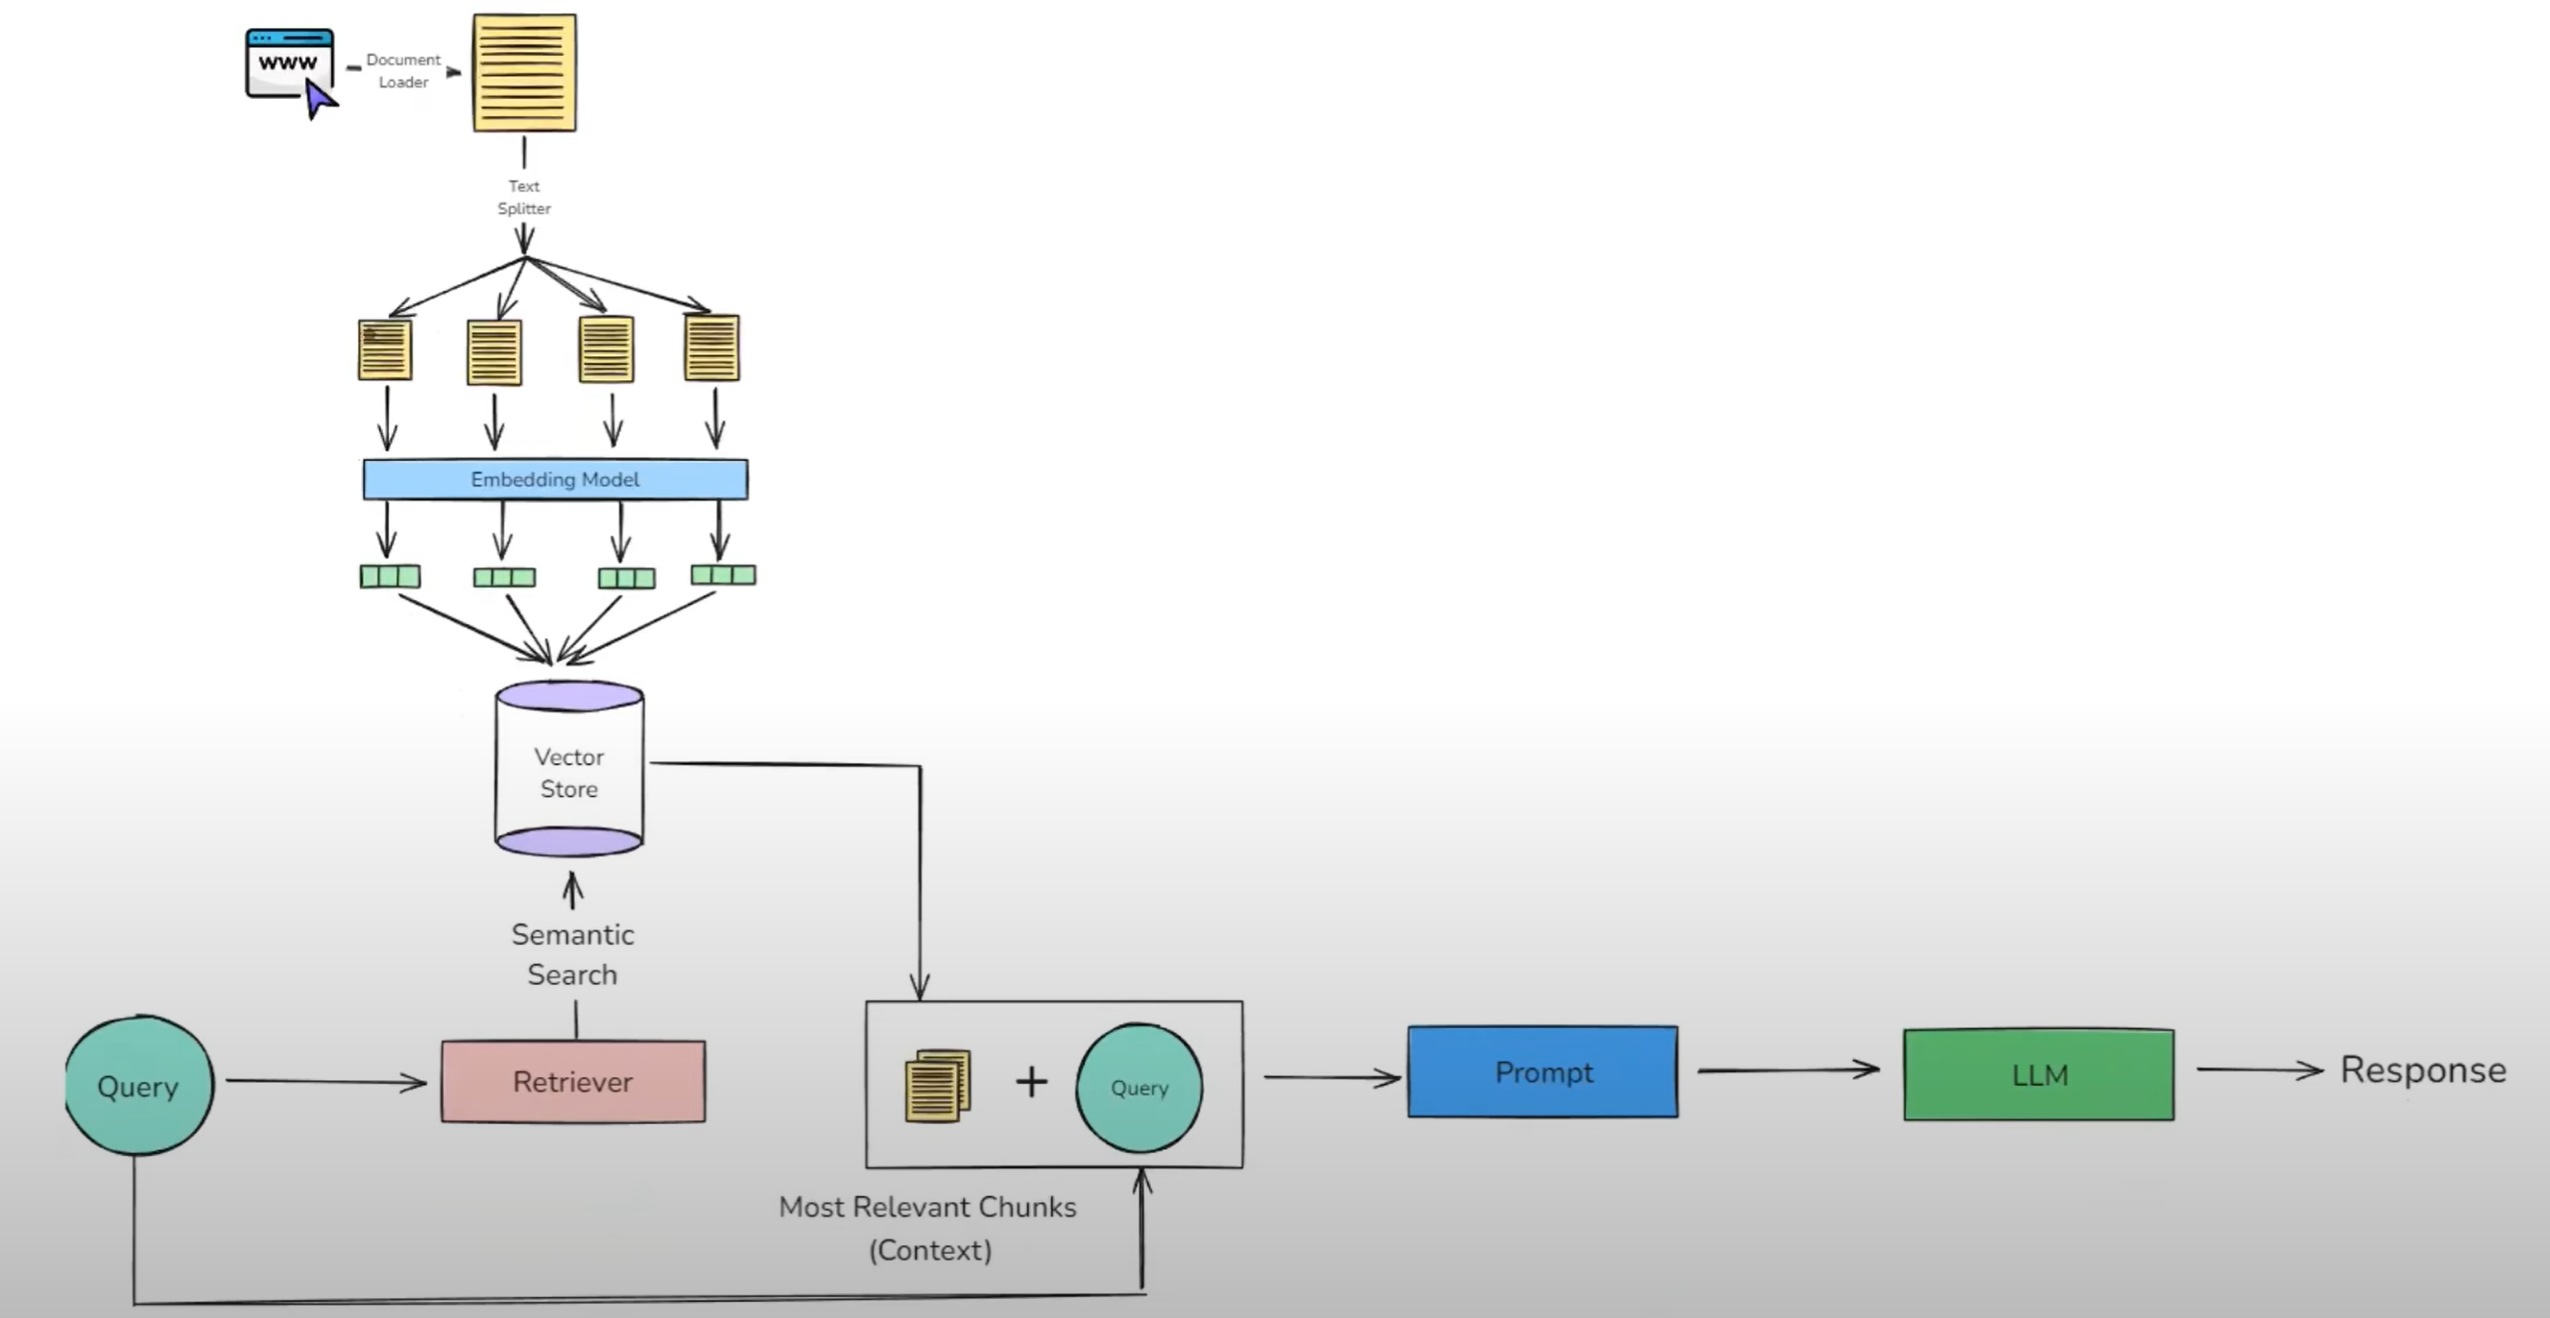

In [ ]:
!pip install -q youtube_transcript_api faiss-cpu tiktoken

In [ ]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import  PromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langchain.schema.runnable import RunnableParallel, RunnableBranch, RunnableLambda, RunnablePassthrough



import os

load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['HF_API_KEY'] = os.getenv('HF_API_KEY')


In [ ]:
# Step 1: Fetch the transcript from YouTube and index it

In [56]:
video_id = 'Gfr50f6ZBvo'  # Replace with your YouTube video ID, not full URL

try:
    transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=['en', 'hi'])
    transcript_text = ' '.join([entry['text'] for entry in transcript])
    print(transcript_text[:500])  # Print the first 500 characters of the transcript

except TranscriptsDisabled:
    print("Transcripts are disabled for this video.")
except Exception as e:
    print(f"An error occurred: {e}")

the following is a conversation with demus hasabis ceo and co-founder of deepmind a company that has published and builds some of the most incredible artificial intelligence systems in the history of computing including alfred zero that learned all by itself to play the game of gold better than any human in the world and alpha fold two that solved protein folding both tasks considered nearly impossible for a very long time demus is widely considered to be one of the most brilliant and impactful 


In [ ]:
# chunking the transcript into smaller pieces

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

chunks = splitter.create_documents([transcript_text])
print(f"Number of chunks: {len(chunks)}")  # Print the number of chunks created

In [ ]:
# store the chunks in a FAISS vector store

In [ ]:
# embedind generation and stoering in FAISS
embeddings = OpenAIEmbeddings(model = "text-embedding-3-small")
vectorstore = FAISS.from_documents(chunks, embeddings)


In [ ]:
vectorstore.index_to_docstore_id

In [ ]:
# Step : Retrieval

In [ ]:
retriever = vectorstore.as_retriever(search_type = "similarity", search_kwargs={"k": 4})  

In [ ]:
retriever

In [ ]:
retriever.invoke("What is deep mind")

In [ ]:
# Augemnted generation
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [ ]:
prompt = PromptTemplate(
    template = "Answer the question based on the context below. If the answer is not in the context, say 'I don't know'.\n\nContext: {context}\n\nQuestion: {question}\n\nAnswer:",
    input_variables=["context", "question"]
)

In [ ]:
question = "What is India plan agains t terrorism against Pakistan"
context = retriever.invoke(question) 
context_text = "\n\n".join(doc.page_content for doc in context)


In [ ]:
final_prompt = prompt.invoke({"context":context_text, "question":question})

In [ ]:
response = llm.invoke(final_prompt)
print(response.content)  # Print the response from the LLM

In [ ]:
# Chaining

In [ ]:
def format_docs(retrieved_docs):
    return "\n\n".join(doc.page_content for doc in retrieved_docs)


In [ ]:
parallell_chain =  RunnableParallel({
    'context': retriever | RunnableLambda( format_docs),
    'question': RunnablePassthrough()
})

In [ ]:
parallell_chain.invoke('who is denis')

In [ ]:
parser =   StrOutputParser()

In [ ]:
main_chain = parallell_chain | prompt | llm | parser

In [ ]:
main_chain.invoke('Can you summarize the video')

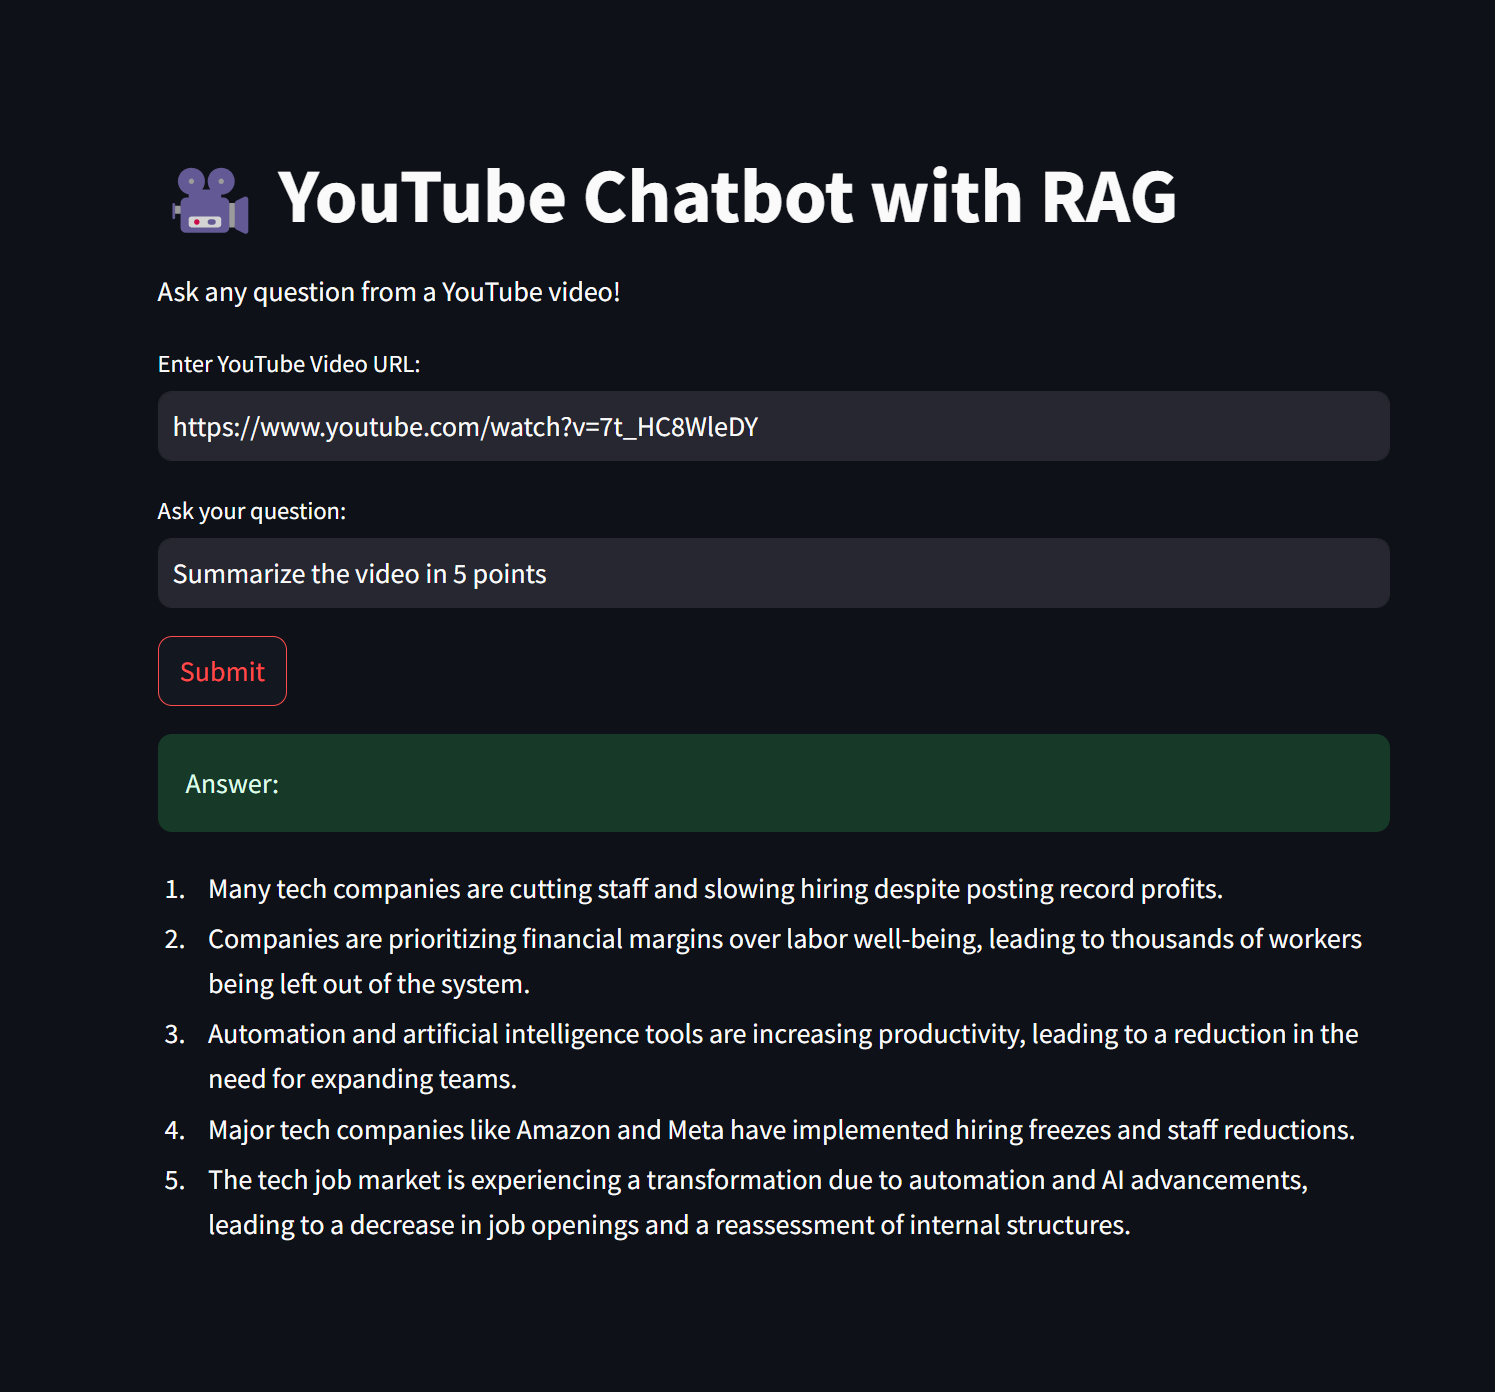